## Conclusion on the Regression Attempts

While `DecisionTreeRegressor` seemed to be as performant as `XGBRegressor` on the `_selcol` datasets, the models trained on those datasets are not particularly desirable (with overall low wellness of fit), this could be due to the loss of features when columns are dropped.

For the datasets that contain all columns, `XGBRegressor` from `xgboost` performs the best when the categorial data are label-encoded. We will tabulate the $R^2$ (on both training and testing set) values from the `XGBRegressor` regressions, attempts on `_selcol` datasets are also added for comparison:

#### On Label-encoding Dataset:

| $R^2$ (train)     | w/ selection | w/o selection |
| :---------------- |-------------:| ------------: |
| w/ outliers       |   0.5774     | 0.8326        |
| w/o outliers      |   0.5576     | 0.8284        |


| $R^2$ (test)      | w/ selection | w/o selection |
| :---------------- |-------------:| ------------: |
| w/ outliers       |   0.58       | 0.83          |
| w/o outliers      |   0.57       | 0.83          |


Note that the presence of outliers slightly increases the wellness of fit on the train set (and the test set).

As an outcome for this machine learning part, we choose the model trained on `train_clean_imputed.csv` (with outliers, with all columns, label-encoded data) as the best model that predicts `TimeTaken`.

To further derive information from the model, we can find out which of the features were the most significant for prediction. In particular, we look at the `gain` of a feature, which is the average of improvements on the model's loss function achieved by partitioning the dataset based on the feature's value.

The code cells below are mostly about repreparing the dataset and retraining the model.

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [19]:
data = pd.read_csv("train_cleaned_imputed.csv")

In [20]:
def label_encoding(datale):
    categorical_columns = datale.select_dtypes(include="object").columns
    label_encoder = LabelEncoder()
    datale[categorical_columns] = datale[categorical_columns].apply(
        lambda col: label_encoder.fit_transform(col)
    )


datale = data
label_encoding(datale)
datale.head()

,Age,Ratings,RestaurantLat,RestaurantLon,DeliveryLocationLat,DeliveryLocationLon,TimeOrderPickedUp,WeatherConditions,RoadTrafficDensity,VehicleCondition,TypeOfOrder,TypeOfVehicle,MultipleDeliveries,Festival,City,TimeTaken,Distance,Day,Hour,OrderPeriod
0,37,4.9,22.745049,75.892471,22.765049,75.912471,46,4,0,2,3,1,0,0,2,24,3.025149,2,11,2
1,34,4.5,12.913041,77.683237,13.043041,77.813237,143,3,1,2,3,2,1,0,0,33,20.183530,0,19,1
2,23,4.4,12.914264,77.678400,12.924264,77.688400,10,2,2,0,1,1,1,0,2,26,1.552758,2,8,2
3,38,4.7,11.003669,76.976494,11.053669,77.026494,123,4,3,0,0,1,1,0,0,21,7.790401,5,18,1
4,32,4.6,12.972793,80.249982,13.012793,80.289982,70,0,0,1,3,2,1,0,0,30,6.210138,2,13,0


In [21]:
X = datale.drop("TimeTaken", axis=1)  # Features
y = datale["TimeTaken"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30264, 19)
(30264,)
(10089, 19)
(10089,)


In [22]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Perform standardization on the training data
X_train = scaler.transform(X_train)

# Perform standardization on the testing data
X_test = scaler.transform(X_test)

In [23]:
# Create a XGB regressor model
model = XGBRegressor(n_estimators=20, max_depth=7)

# Fit the model on the training data
model.fit(X_train, y_train)

# Get feature importance
f_importance = model.get_booster().get_score(importance_type="gain")

<Axes: >

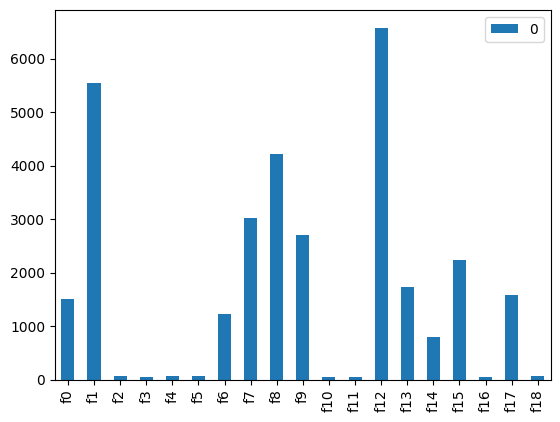

In [24]:
# visualise the importance of features
importance_df = pd.DataFrame.from_dict(data=f_importance, orient="index")
importance_df.plot.bar()

```
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  40353 non-null  int64  
 1   Ratings              40353 non-null  float64
 2   RestaurantLat        40353 non-null  float64
 3   RestaurantLon        40353 non-null  float64
 4   DeliveryLocationLat  40353 non-null  float64
 5   DeliveryLocationLon  40353 non-null  float64
 6   TimeOrderPickedUp    40353 non-null  object 
 7   WeatherConditions    40353 non-null  object 
 8   RoadTrafficDensity   40353 non-null  object 
 9   VehicleCondition     40353 non-null  int64  
 10  TypeOfOrder          40353 non-null  object 
 11  TypeOfVehicle        40353 non-null  object 
 12  MultipleDeliveries   40353 non-null  int64  
 13  Festival             40353 non-null  object 
 14  City                 40353 non-null  object 
 15  TimeTaken            40353 non-null  int64  
 16  Distance             40353 non-null  float64
 17  Day                  40353 non-null  object 
 18  Hour                 40353 non-null  int64  
 19  OrderPeriod          40353 non-null  object 
```

^ use the list above to retrieve the name of each feature by their indices

From this, we can conclude that, the top three most significant features for prediction is, from the first place, `MultipleDeliveries`, `Ratings`, and lastly `RoadTrafficDensity`.